## **[ROBUST SUBSPACE RECOVERY LAYER IMPLEMENTATION IN PYTORCH](https://zablo.net/blog/post/robust-space-recovery-rsrlayer-pytorch/)**

Anomaly detection (or outlier detection) is one of the many tasks that keep Data Scientists awake at night when then need to satisfy the business needs. No matter whether the data in well structured (like user events) or unstructured (like text or images), there are plenty of methods that allow to tackle this problem and it’s diffictult to choose one. Sometimes, it’s even difficult to properly define, what an anomaly is - but that’s not the part of this post’s main focus. Some of the most popular methods for anomaly detection are:

- statistical methods - like three-sigma rule and regression models
- classical machine learning methods - like one-class SVM, Isolation Forests or clustering-based methods (e.g. kNN)
- deep learning methods - like autoencoders and deep forecasting models (e.g. LSTMs for time series)

In this post I will focus on a single method called Robust Subspace Recovery Layer for Unsupervised Anomaly Detection (https://arxiv.org/abs/1904.00152) which is an extension of the autoencoder-based unsupervised anomnaly detection method for data of any domain.

### **TL;DR**
Implementation of RSR Layer and RSR Autoencoder (RSRAE) in PyTorch. Link to Jupyter Notebook / Google Colab at the bottom.
> Note: This post and my implementation does not reproduce RSR Layer paper. I only explain the general idea and provide minimal working code as a form of proof-of-concept.

### **Idea behind Robust Space Recovery Layer**
Autoencoders were used for the anomaly detection much earlier than this (RSR) paper appeared. To use autoencoder in a setting of anomaly detection, one treats “normal” examples (inliers) as the ones that have low reconstruction error and other which have high reconstruction error are treated as outliers. Although the idea is fairly easy to understand and implement, the problem lies in the fact that in order for autoencoder to work properly in this setting (i.e. to detect the outliers) the training data should be clean (or have really small fraction of the outliers). In the real world it’s highly unlikely for the input data to be free of any anomalies and even if Data Scientists could label and filter the data (given they know what an anomaly in the given dataset is) it simply won’t scale.

The Robust Subspace Recovery Layer paper tries to adress this issue by incorporating the RSR Layer into autoencoders. It’s clearly stated that this method does not compete with semi-supervised or supervised anomaly detection setting, but shows its strenght in the unsupervised setting.

__*What is the RSR Layer?*__

The RSR Layer itself is just an additional layer in the nerual network with specific properties. It maps one representation (embedding obtained from the encoder) into another **low-dimensional representation that is outlier-robust**.

Let’s say that $D$ (upper case D) is the dimension of the embedding from the encoder. The assumption in the paper is that the “normal” data lies within d-dimensional (lower case $d$) manifold (“subspace”) of the original embedding, which means that $d < D$.

Please refer to the paper to obtain more details and the full explanation and analysis. At this point you should know enough to proceed to the implementation section.

### **How to implement the RSR Layer in PyTorch?**
As RSR Layer is just a linear mapping, there are only a few things needed:
1. The dimension D from the encoder’s output.
2. The dimension d which is a direct property of the RSR Layer (and probably requires a hyperparamer search to set it properly).
3. Proper initialization of the linear mapping weights (the optimization goal of the RSR Autoencoder enforces that, so it’s better to start with a set of weights that already fulfill this constraint).

The implementation of the layer itself is straightforward.

```python
import torch
from torch import nn
import torch.nn.functional as F
```

```python
class RSRLayer(nn.Module):
    def __init__(self, d:int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        # z is the output from the encoder
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)
```

The next piece to obtain RSR Autoencoder in PyTorch is to implement RSR Loss as per paper’s equation (4):

<center> <p>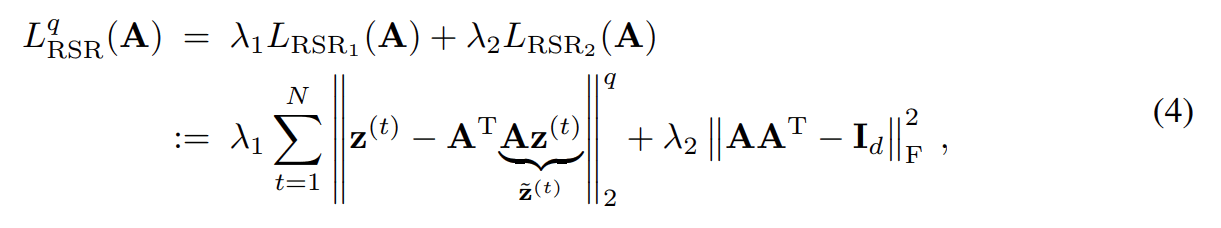</p> </center>

The first term enforces the RSR Layer projection to be robust and the second term enforces the projection to be orthogonal. Refer to the paper for the motivation behind this loss as it it out of scope for this blog post.

Nearly op-for-op (math-to-PyTorch) implementation of this loss looks like this:

```python
class RSRLoss(nn.Module):
    def __init__(self, lambda1, lambda2, d, D):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2
```

Lastly, the standard L1/L2 reconstruction loss is replaced by the L2,p-norm based loss (again, the paper relies on “more robustness”, wiki: https://en.wikipedia.org/wiki/Matrix_norm#L2,1_and_Lp,q_norms). In practice, the paper uses L2,1 version.

<center> <p>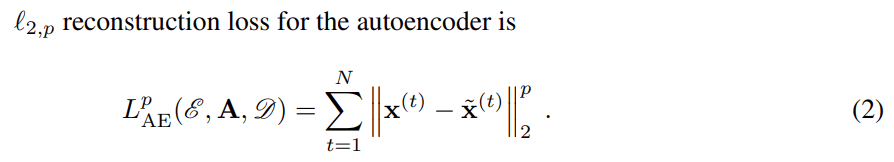</p> </center>

```python
class L2p_Loss(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.p = p
  
    def forward(self, y_hat, y):
        return torch.sum(
            torch.pow(
                torch.norm(y - y_hat, p=2), self.p
            )
        )
```